# Identifying Intern and Student Effects in Citi Bike Ridership

## Research Question
Can we identify distinct ridership patterns attributable to:
1. **Summer interns** (finance industry, June-August)
2. **College students** (academic year, September-May)

## Identification Strategy
We use multiple layers of evidence to isolate these effects:

1. **Step-change detection**: Look for discrete jumps aligned with program dates
2. **Age-specific analysis**: Compare 20-25 (target) vs 35-45 (control) at same locations
3. **Location specificity**: Compare treated locations (banks/colleges) vs control locations
4. **Difference-in-differences**: Combine location and time variation

## Key Dates
| Population | Arrival | Departure |
|------------|---------|----------|
| Finance interns | June 5-12 | August 10-15 |
| College students | August 28 - Sept 5 | May 10-15 |

## Control Strategy
- **Age control**: 35-45 year olds (same location, different age)
- **Location control**: Non-bank commercial areas (same age, different location)
- **Within-group control**: Same population in off-season

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Colors
INTERN_COLOR = '#e74c3c'  # Red
STUDENT_COLOR = '#3498db'  # Blue
CONTROL_COLOR = '#95a5a6'  # Gray
YOUNG_COLOR = '#f39c12'   # Orange
OLD_COLOR = '#2c3e50'     # Dark

con = duckdb.connect()
print('Connected to DuckDB')

Connected to DuckDB


## 1. Define Treatment and Control Locations

We need to carefully define our location groups.

In [2]:
# Get all stations with sufficient data
all_stations = con.execute("""
    SELECT 
        start_station_name as station,
        start_lat as lat,
        start_lon as lon,
        COUNT(*) as total_trips
    FROM '../data/processed/*.parquet'
    WHERE birth_year_valid = TRUE AND gender_valid = TRUE
      AND start_lat IS NOT NULL
    GROUP BY 1, 2, 3
    HAVING COUNT(*) >= 10000
""").fetchdf()

print(f"Stations with 10k+ demographic trips: {len(all_stations)}")

Stations with 10k+ demographic trips: 716


In [3]:
# Define key locations with coordinates
# These are the HQ addresses of major banks and universities

BANK_HQ_LOCATIONS = {
    'Goldman Sachs': (-74.0135, 40.7145),      # 200 West St
    'JPMorgan Chase': (-73.9762, 40.7567),     # 383 Madison Ave
    'Citigroup': (-74.0103, 40.7201),          # 388 Greenwich St
    'Bank of America': (-73.9840, 40.7556),    # One Bryant Park
    'Morgan Stanley': (-73.9850, 40.7600),     # 1585 Broadway
    'Deutsche Bank': (-73.9890, 40.7527),      # 60 Wall St (moved to Columbus Circle)
    'Barclays': (-73.9873, 40.7565),           # 745 7th Ave
    'Credit Suisse': (-73.9830, 40.7615),      # 11 Madison Ave
    'UBS': (-73.9750, 40.7560),                # 1285 6th Ave
}

UNIVERSITY_LOCATIONS = {
    'NYU Main': (-73.9973, 40.7308),           # Washington Square
    'NYU Stern': (-73.9955, 40.7290),          # Business school
    'Columbia Main': (-73.9626, 40.8075),      # Morningside
    'Columbia Business': (-73.9610, 40.8190),  # Uris Hall
    'Baruch College': (-73.9833, 40.7403),     # 25th & Lex
    'Pace University': (-74.0040, 40.7112),    # City Hall area
    'The New School': (-73.9937, 40.7353),     # 14th St
    'FIT': (-73.9950, 40.7465),                # Fashion Institute
    'Hunter College': (-73.9645, 40.7685),     # 68th & Lex
}

# Control: Commercial areas that are NOT banks or universities
# (Tech, Media, Advertising, Law firms)
CONTROL_COMMERCIAL_LOCATIONS = {
    'Chelsea/Flatiron Tech': (-73.9900, 40.7400),  # Startup alley
    'Hudson Yards': (-74.0020, 40.7530),           # New development
    'Times Square Media': (-73.9855, 40.7580),     # Media companies
    'SoHo': (-74.0000, 40.7230),                   # Retail/creative
    'Tribeca': (-74.0080, 40.7160),                # Mixed commercial
}

def find_nearby_stations(locations_dict, stations_df, radius_deg=0.003):
    """Find stations within ~300m of each location"""
    nearby = []
    for name, (lon, lat) in locations_dict.items():
        mask = ((stations_df['lon'] - lon).abs() < radius_deg) & \
               ((stations_df['lat'] - lat).abs() < radius_deg)
        stations = stations_df[mask]['station'].tolist()
        nearby.extend(stations)
    return list(set(nearby))  # Deduplicate

bank_stations = find_nearby_stations(BANK_HQ_LOCATIONS, all_stations)
university_stations = find_nearby_stations(UNIVERSITY_LOCATIONS, all_stations)
control_stations = find_nearby_stations(CONTROL_COMMERCIAL_LOCATIONS, all_stations)

# Remove any overlap (station near both bank and control)
control_stations = [s for s in control_stations if s not in bank_stations and s not in university_stations]

print(f"Bank-adjacent stations: {len(bank_stations)}")
print(f"University-adjacent stations: {len(university_stations)}")
print(f"Control commercial stations: {len(control_stations)}")

print(f"\nSample bank stations: {bank_stations[:5]}")
print(f"Sample university stations: {university_stations[:5]}")
print(f"Sample control stations: {control_stations[:5]}")

Bank-adjacent stations: 24
University-adjacent stations: 35
Control commercial stations: 17

Sample bank stations: ['E 47 St & Park Ave', 'North Moore St & Greenwich St', 'Greenwich St & Hubert St', 'Murray St & West St', '6 Ave & W 45 St']
Sample university stations: ['E 24 St & Park Ave S', 'E 68 St & 3 Ave', 'Centre St & Chambers St', 'Fulton St & William St', 'University Pl & E 8 St']
Sample control stations: ['Warren St & W Broadway', '10 Hudson Yards', 'W Broadway & Spring St', 'E 17 St & Broadway', 'Broadway & W 25 St']


## 2. Build the Analysis Dataset

We'll create a weekly aggregated dataset with all the dimensions we need.

In [4]:
# Create weekly aggregated data by location type, age group, and commute pattern
# Only using years 2014-2019 (full years with demographics)

weekly_data = con.execute("""
    WITH categorized AS (
        SELECT 
            DATE_TRUNC('week', started_at) as week,
            EXTRACT(YEAR FROM started_at) as year,
            EXTRACT(MONTH FROM started_at) as month,
            EXTRACT(HOUR FROM started_at) as hour,
            DAYOFWEEK(started_at) as dow,
            start_station_name as station,
            end_station_name as end_station,
            age_at_trip,
            gender,
            member_casual
        FROM '../data/processed/*.parquet'
        WHERE birth_year_valid = TRUE 
          AND gender_valid = TRUE
          AND EXTRACT(YEAR FROM started_at) BETWEEN 2014 AND 2019
    )
    SELECT 
        week,
        year,
        month,
        -- Age groups
        CASE 
            WHEN age_at_trip BETWEEN 20 AND 25 THEN 'young_20_25'
            WHEN age_at_trip BETWEEN 26 AND 30 THEN 'young_26_30'
            WHEN age_at_trip BETWEEN 35 AND 45 THEN 'control_35_45'
            ELSE 'other'
        END as age_group,
        -- Gender
        CASE WHEN gender = 1 THEN 'male' ELSE 'female' END as gender,
        -- Is commute hour (7-9am or 5-7pm on weekdays)
        CASE 
            WHEN dow NOT IN (0, 6) AND (hour BETWEEN 7 AND 9 OR hour BETWEEN 17 AND 19) 
            THEN 'commute' ELSE 'non_commute' 
        END as trip_type,
        -- Location type (origin)
        CASE 
            WHEN station IN (SELECT UNNEST(?::VARCHAR[])) THEN 'bank'
            WHEN station IN (SELECT UNNEST(?::VARCHAR[])) THEN 'university'
            WHEN station IN (SELECT UNNEST(?::VARCHAR[])) THEN 'control'
            ELSE 'other'
        END as origin_type,
        -- Location type (destination)
        CASE 
            WHEN end_station IN (SELECT UNNEST(?::VARCHAR[])) THEN 'bank'
            WHEN end_station IN (SELECT UNNEST(?::VARCHAR[])) THEN 'university'
            WHEN end_station IN (SELECT UNNEST(?::VARCHAR[])) THEN 'control'
            ELSE 'other'
        END as dest_type,
        member_casual,
        COUNT(*) as trips
    FROM categorized
    GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9
""", [bank_stations, university_stations, control_stations,
      bank_stations, university_stations, control_stations]).fetchdf()

print(f"Weekly dataset shape: {weekly_data.shape}")
print(f"Date range: {weekly_data['week'].min()} to {weekly_data['week'].max()}")
print(f"\nTrips by location type:")
print(weekly_data.groupby('origin_type')['trips'].sum().sort_values(ascending=False))

Weekly dataset shape: (134709, 10)
Date range: 2013-12-30 00:00:00 to 2019-12-30 00:00:00

Trips by location type:
origin_type
other         62210885
university     6166470
bank           5248155
control        3663610
Name: trips, dtype: int64


## 3. Step-Change Analysis: Weekly Time Series

If interns arrive June 5-12, we should see a **discrete jump** in ridership at bank stations for 20-25 year olds.

Key insight: Weather effects are **gradual**. Intern effects should be **step functions**.

In [5]:
# Focus on commute trips TO banks (morning) by young males
# This is the most likely "intern signal"

def get_weekly_series(df, dest_type, age_group, gender='male', trip_type='commute'):
    """Aggregate to weekly series for specific filters"""
    mask = (df['dest_type'] == dest_type) & \
           (df['age_group'] == age_group) & \
           (df['gender'] == gender) & \
           (df['trip_type'] == trip_type)
    return df[mask].groupby('week')['trips'].sum().reset_index()

# Get series for different groups
young_to_banks = get_weekly_series(weekly_data, 'bank', 'young_20_25')
control_age_to_banks = get_weekly_series(weekly_data, 'bank', 'control_35_45')
young_to_control = get_weekly_series(weekly_data, 'control', 'young_20_25')

print(f"Young (20-25) male commute trips TO banks: {young_to_banks['trips'].sum():,}")
print(f"Control (35-45) male commute trips TO banks: {control_age_to_banks['trips'].sum():,}")
print(f"Young (20-25) male commute trips TO control areas: {young_to_control['trips'].sum():,}")

Young (20-25) male commute trips TO banks: 156,226
Control (35-45) male commute trips TO banks: 627,368
Young (20-25) male commute trips TO control areas: 109,502


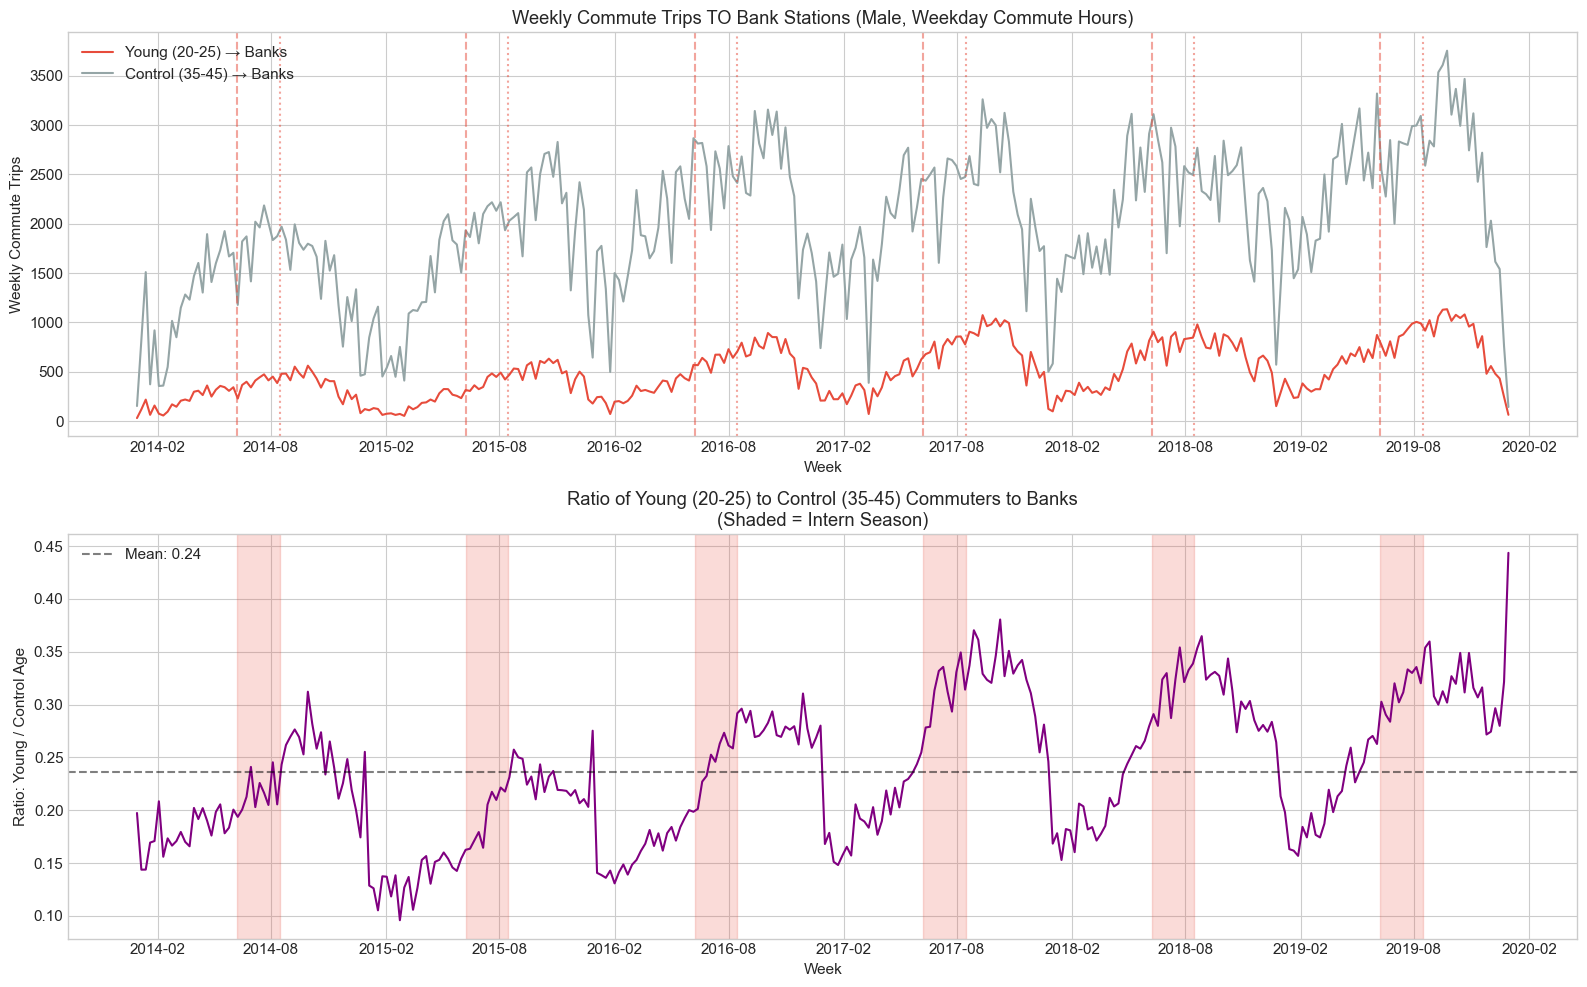

In [6]:
# Plot multi-year weekly series to look for consistent patterns
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Top: Absolute numbers
ax1 = axes[0]
ax1.plot(young_to_banks['week'], young_to_banks['trips'], 
         label='Young (20-25) → Banks', color=INTERN_COLOR, linewidth=1.5)
ax1.plot(control_age_to_banks['week'], control_age_to_banks['trips'], 
         label='Control (35-45) → Banks', color=CONTROL_COLOR, linewidth=1.5)

# Add vertical lines for intern start (June week 2) each year
for year in range(2014, 2020):
    intern_start = pd.Timestamp(f'{year}-06-08')
    intern_end = pd.Timestamp(f'{year}-08-15')
    ax1.axvline(x=intern_start, color=INTERN_COLOR, linestyle='--', alpha=0.5)
    ax1.axvline(x=intern_end, color=INTERN_COLOR, linestyle=':', alpha=0.5)

ax1.set_xlabel('Week')
ax1.set_ylabel('Weekly Commute Trips')
ax1.set_title('Weekly Commute Trips TO Bank Stations (Male, Weekday Commute Hours)')
ax1.legend()
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Bottom: Ratio of young/control (controls for seasonality)
ax2 = axes[1]
merged = young_to_banks.merge(control_age_to_banks, on='week', suffixes=('_young', '_control'))
merged['ratio'] = merged['trips_young'] / merged['trips_control']

ax2.plot(merged['week'], merged['ratio'], color='purple', linewidth=1.5)
ax2.axhline(y=merged['ratio'].mean(), color='black', linestyle='--', alpha=0.5, 
            label=f'Mean: {merged["ratio"].mean():.2f}')

# Add intern period shading
for year in range(2014, 2020):
    intern_start = pd.Timestamp(f'{year}-06-08')
    intern_end = pd.Timestamp(f'{year}-08-15')
    ax2.axvspan(intern_start, intern_end, alpha=0.2, color=INTERN_COLOR)

ax2.set_xlabel('Week')
ax2.set_ylabel('Ratio: Young / Control Age')
ax2.set_title('Ratio of Young (20-25) to Control (35-45) Commuters to Banks\n(Shaded = Intern Season)')
ax2.legend()
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

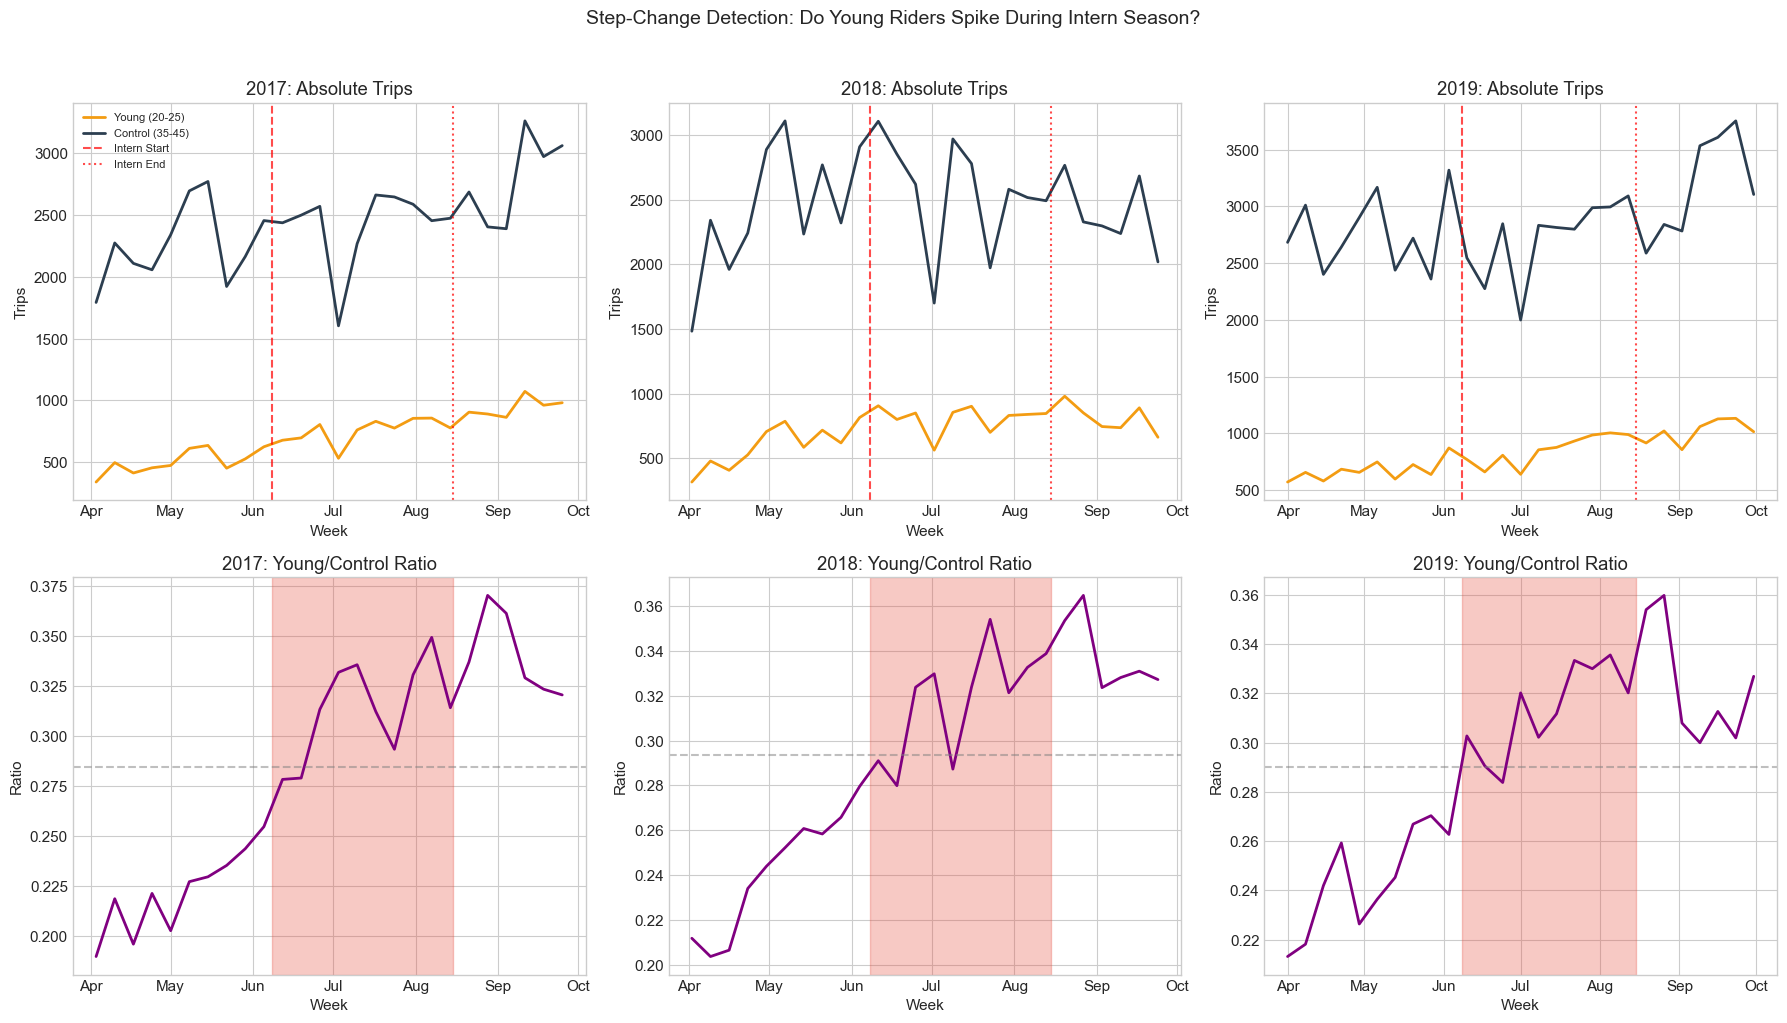

In [7]:
# Zoom in on a single year to see the step-change more clearly
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, year in enumerate([2017, 2018, 2019]):
    # Filter to this year, April-September
    mask = (merged['week'] >= f'{year}-04-01') & (merged['week'] <= f'{year}-09-30')
    year_data = merged[mask].copy()
    
    # Top row: absolute
    ax = axes[0, idx]
    ax.plot(year_data['week'], year_data['trips_young'], label='Young (20-25)', color=YOUNG_COLOR, linewidth=2)
    ax.plot(year_data['week'], year_data['trips_control'], label='Control (35-45)', color=OLD_COLOR, linewidth=2)
    
    # Mark intern period
    ax.axvline(x=pd.Timestamp(f'{year}-06-08'), color='red', linestyle='--', alpha=0.7, label='Intern Start')
    ax.axvline(x=pd.Timestamp(f'{year}-08-15'), color='red', linestyle=':', alpha=0.7, label='Intern End')
    
    ax.set_title(f'{year}: Absolute Trips')
    ax.set_xlabel('Week')
    ax.set_ylabel('Trips')
    if idx == 0:
        ax.legend(fontsize=8)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    # Bottom row: ratio
    ax = axes[1, idx]
    ax.plot(year_data['week'], year_data['ratio'], color='purple', linewidth=2)
    ax.axhline(y=year_data['ratio'].mean(), color='gray', linestyle='--', alpha=0.5)
    
    # Shade intern period
    ax.axvspan(pd.Timestamp(f'{year}-06-08'), pd.Timestamp(f'{year}-08-15'), 
               alpha=0.3, color=INTERN_COLOR, label='Intern Season')
    
    ax.set_title(f'{year}: Young/Control Ratio')
    ax.set_xlabel('Week')
    ax.set_ylabel('Ratio')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.suptitle('Step-Change Detection: Do Young Riders Spike During Intern Season?', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 4. Difference-in-Differences: Banks vs Control Locations

Compare the change in young riders at banks vs. control commercial areas.

If banks have a unique "intern effect", the increase in young riders should be larger at banks than at control locations.

In [8]:
# Calculate monthly aggregates for cleaner DiD
monthly_did = weekly_data.groupby(['year', 'month', 'dest_type', 'age_group', 'gender', 'trip_type'])['trips'].sum().reset_index()

# Define periods
def get_period(month):
    if month in [6, 7, 8]:
        return 'summer_intern'
    elif month in [9, 10, 11, 12, 1, 2, 3, 4, 5]:
        return 'academic_year'
    else:
        return 'other'

monthly_did['period'] = monthly_did['month'].apply(get_period)

# Focus on young males during commute
young_male_commute = monthly_did[
    (monthly_did['age_group'] == 'young_20_25') & 
    (monthly_did['gender'] == 'male') & 
    (monthly_did['trip_type'] == 'commute')
]

# Compare banks vs control
banks_summer = young_male_commute[
    (young_male_commute['dest_type'] == 'bank') & 
    (young_male_commute['period'] == 'summer_intern')
]['trips'].sum()

banks_academic = young_male_commute[
    (young_male_commute['dest_type'] == 'bank') & 
    (young_male_commute['period'] == 'academic_year')
]['trips'].sum()

control_summer = young_male_commute[
    (young_male_commute['dest_type'] == 'control') & 
    (young_male_commute['period'] == 'summer_intern')
]['trips'].sum()

control_academic = young_male_commute[
    (young_male_commute['dest_type'] == 'control') & 
    (young_male_commute['period'] == 'academic_year')
]['trips'].sum()

# Normalize by months (3 summer, 9 academic)
banks_summer_monthly = banks_summer / 3
banks_academic_monthly = banks_academic / 9
control_summer_monthly = control_summer / 3
control_academic_monthly = control_academic / 9

print("Difference-in-Differences: Young (20-25) Male Commuters")
print("=" * 60)
print(f"\n{'':20} {'Academic Year':>15} {'Summer':>15} {'Δ':>15}")
print(f"{'':20} {'(per month)':>15} {'(per month)':>15} {'(%)':>15}")
print("-" * 65)

banks_change = (banks_summer_monthly - banks_academic_monthly) / banks_academic_monthly * 100
control_change = (control_summer_monthly - control_academic_monthly) / control_academic_monthly * 100

print(f"{'Bank Stations':20} {banks_academic_monthly:>15,.0f} {banks_summer_monthly:>15,.0f} {banks_change:>+14.1f}%")
print(f"{'Control Stations':20} {control_academic_monthly:>15,.0f} {control_summer_monthly:>15,.0f} {control_change:>+14.1f}%")
print("-" * 65)
print(f"{'DiD Effect':20} {' ':>15} {' ':>15} {banks_change - control_change:>+14.1f}%")
print("\nInterpretation: The DiD effect isolates the 'intern effect' at banks")
print("beyond general summer seasonality.")

Difference-in-Differences: Young (20-25) Male Commuters

                       Academic Year          Summer               Δ
                         (per month)     (per month)             (%)
-----------------------------------------------------------------
Bank Stations                 11,672          17,059          +46.2%
Control Stations               8,255          11,735          +42.2%
-----------------------------------------------------------------
DiD Effect                                                     +4.0%

Interpretation: The DiD effect isolates the 'intern effect' at banks
beyond general summer seasonality.


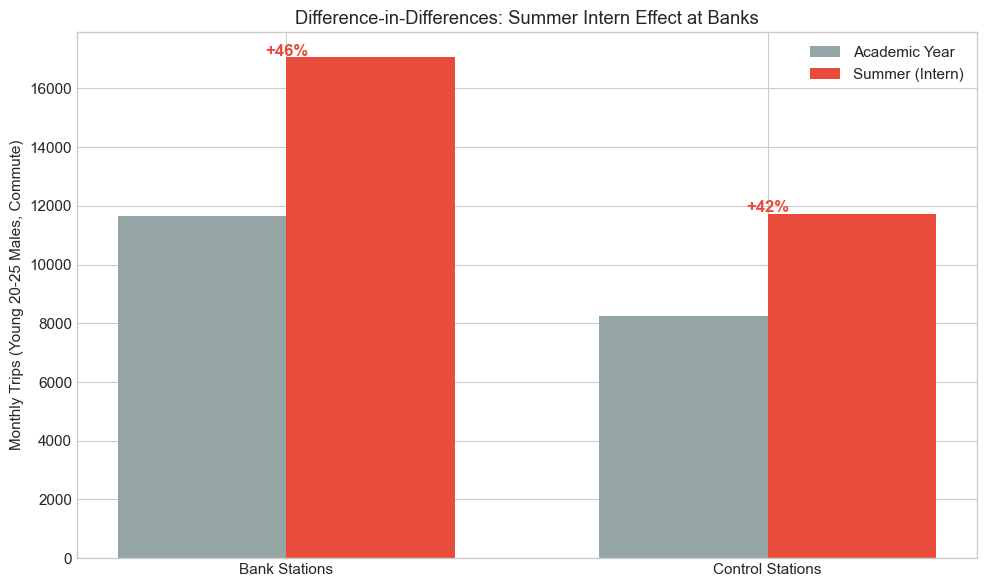


DiD Effect: Banks increase 4.0pp MORE than control areas in summer.
This is the estimated 'intern effect' controlling for general summer seasonality.


In [9]:
# Visualize DiD
fig, ax = plt.subplots(figsize=(10, 6))

x = np.array([0, 1])
width = 0.35

# Banks
ax.bar(x[0] - width/2, banks_academic_monthly, width, label='Academic Year', color=CONTROL_COLOR)
ax.bar(x[0] + width/2, banks_summer_monthly, width, label='Summer (Intern)', color=INTERN_COLOR)

# Control
ax.bar(x[1] - width/2, control_academic_monthly, width, color=CONTROL_COLOR)
ax.bar(x[1] + width/2, control_summer_monthly, width, color=INTERN_COLOR)

# Add change annotations
ax.annotate(f'+{banks_change:.0f}%', xy=(0, max(banks_academic_monthly, banks_summer_monthly) + 50),
            ha='center', fontsize=12, fontweight='bold', color=INTERN_COLOR)
ax.annotate(f'+{control_change:.0f}%', xy=(1, max(control_academic_monthly, control_summer_monthly) + 50),
            ha='center', fontsize=12, fontweight='bold', color=INTERN_COLOR)

ax.set_xticks(x)
ax.set_xticklabels(['Bank Stations', 'Control Stations'])
ax.set_ylabel('Monthly Trips (Young 20-25 Males, Commute)')
ax.set_title('Difference-in-Differences: Summer Intern Effect at Banks')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nDiD Effect: Banks increase {banks_change - control_change:.1f}pp MORE than control areas in summer.")
print(f"This is the estimated 'intern effect' controlling for general summer seasonality.")

## 5. Age-Specific Within-Location Control

At the SAME bank stations, compare:
- 20-25 year olds (includes interns)
- 35-45 year olds (full-time employees only, no interns)

If the ratio of young/old increases in summer, that's evidence of interns.

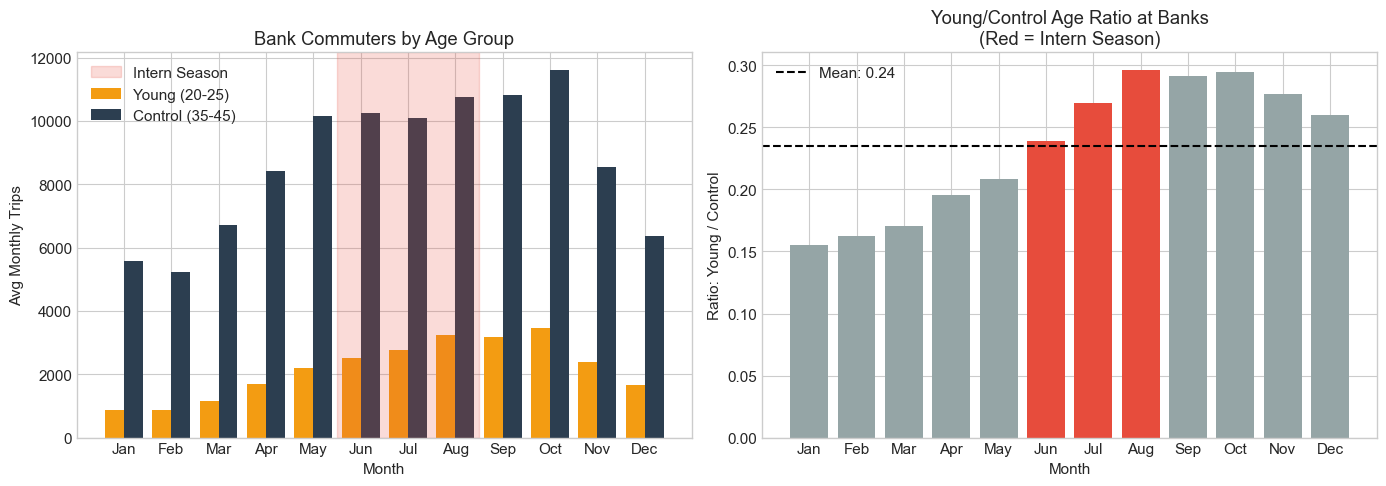


Average Young/Control ratio:
  Summer (Jun-Aug): 0.268
  Non-summer: 0.224
  Difference: +19.9%


In [10]:
# Calculate young/old ratio at banks by month
bank_by_age = monthly_did[
    (monthly_did['dest_type'] == 'bank') & 
    (monthly_did['gender'] == 'male') & 
    (monthly_did['trip_type'] == 'commute') &
    (monthly_did['age_group'].isin(['young_20_25', 'control_35_45']))
].copy()

# Pivot to get young and control side by side
bank_age_pivot = bank_by_age.groupby(['year', 'month', 'age_group'])['trips'].sum().unstack('age_group').fillna(0)
bank_age_pivot['ratio'] = bank_age_pivot['young_20_25'] / bank_age_pivot['control_35_45']
bank_age_pivot = bank_age_pivot.reset_index()

# Average by month across years
avg_by_month = bank_age_pivot.groupby('month').agg({
    'young_20_25': 'mean',
    'control_35_45': 'mean',
    'ratio': 'mean'
}).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Absolute by month
ax1 = axes[0]
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x = np.arange(12)

ax1.bar(x - 0.2, avg_by_month['young_20_25'], 0.4, label='Young (20-25)', color=YOUNG_COLOR)
ax1.bar(x + 0.2, avg_by_month['control_35_45'], 0.4, label='Control (35-45)', color=OLD_COLOR)

# Shade intern months
ax1.axvspan(4.5, 7.5, alpha=0.2, color=INTERN_COLOR, label='Intern Season')

ax1.set_xticks(x)
ax1.set_xticklabels(month_labels)
ax1.set_xlabel('Month')
ax1.set_ylabel('Avg Monthly Trips')
ax1.set_title('Bank Commuters by Age Group')
ax1.legend()

# Right: Ratio by month
ax2 = axes[1]
colors = [INTERN_COLOR if m in [6, 7, 8] else CONTROL_COLOR for m in range(1, 13)]
ax2.bar(x, avg_by_month['ratio'], color=colors)
ax2.axhline(y=avg_by_month['ratio'].mean(), color='black', linestyle='--', 
            label=f'Mean: {avg_by_month["ratio"].mean():.2f}')

ax2.set_xticks(x)
ax2.set_xticklabels(month_labels)
ax2.set_xlabel('Month')
ax2.set_ylabel('Ratio: Young / Control')
ax2.set_title('Young/Control Age Ratio at Banks\n(Red = Intern Season)')
ax2.legend()

plt.tight_layout()
plt.show()

# Calculate the summer vs non-summer ratio difference
summer_ratio = avg_by_month[avg_by_month['month'].isin([6, 7, 8])]['ratio'].mean()
nonsummer_ratio = avg_by_month[~avg_by_month['month'].isin([6, 7, 8])]['ratio'].mean()
print(f"\nAverage Young/Control ratio:")
print(f"  Summer (Jun-Aug): {summer_ratio:.3f}")
print(f"  Non-summer: {nonsummer_ratio:.3f}")
print(f"  Difference: {(summer_ratio - nonsummer_ratio) / nonsummer_ratio * 100:+.1f}%")

## 6. Student Effect: University Stations

Now let's look at the opposite pattern: students should be ABSENT in summer and PRESENT during academic year.

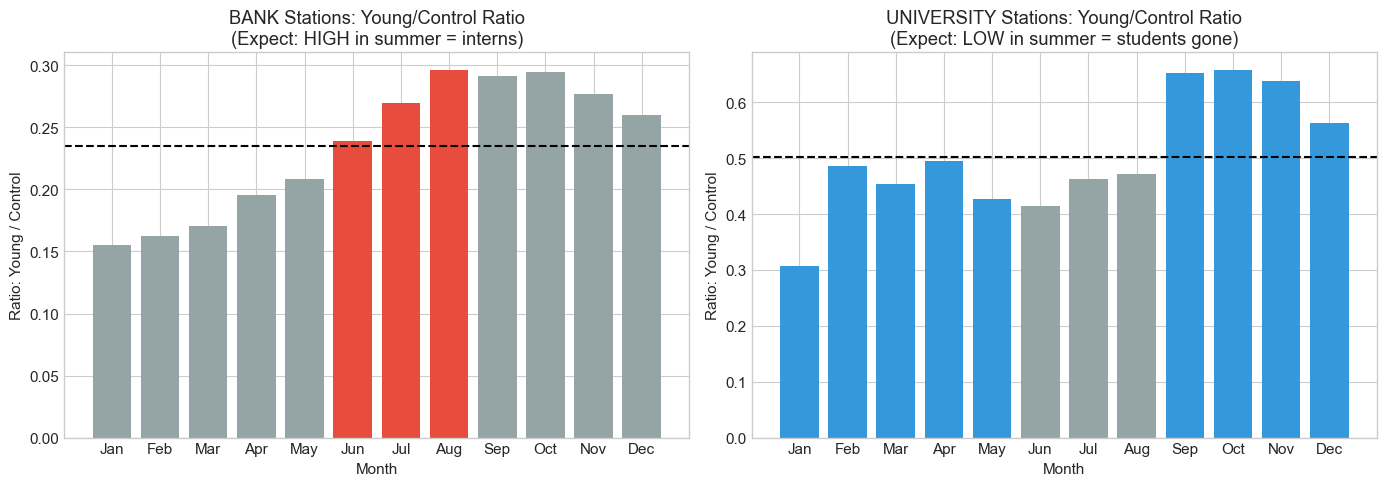


University stations - Young/Control ratio:
  Summer (Jun-Aug): 0.450
  Academic year: 0.520
  Difference: -13.5%


In [11]:
# University stations analysis
uni_by_age = monthly_did[
    (monthly_did['dest_type'] == 'university') & 
    (monthly_did['gender'] == 'male') & 
    (monthly_did['trip_type'] == 'commute') &
    (monthly_did['age_group'].isin(['young_20_25', 'control_35_45']))
].copy()

uni_age_pivot = uni_by_age.groupby(['year', 'month', 'age_group'])['trips'].sum().unstack('age_group').fillna(0)
uni_age_pivot['ratio'] = uni_age_pivot['young_20_25'] / (uni_age_pivot['control_35_45'] + 1)  # +1 to avoid div by zero
uni_age_pivot = uni_age_pivot.reset_index()

uni_avg_by_month = uni_age_pivot.groupby('month').agg({
    'young_20_25': 'mean',
    'control_35_45': 'mean',
    'ratio': 'mean'
}).reset_index()

# Compare banks vs universities
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Banks ratio
ax1 = axes[0]
ax1.bar(x, avg_by_month['ratio'], color=[INTERN_COLOR if m in [6, 7, 8] else CONTROL_COLOR for m in range(1, 13)])
ax1.axhline(y=avg_by_month['ratio'].mean(), color='black', linestyle='--')
ax1.set_xticks(x)
ax1.set_xticklabels(month_labels)
ax1.set_xlabel('Month')
ax1.set_ylabel('Ratio: Young / Control')
ax1.set_title('BANK Stations: Young/Control Ratio\n(Expect: HIGH in summer = interns)')

# Right: University ratio
ax2 = axes[1]
# For universities, highlight academic year (Sept-May)
colors_uni = [STUDENT_COLOR if m not in [6, 7, 8] else CONTROL_COLOR for m in range(1, 13)]
ax2.bar(x, uni_avg_by_month['ratio'], color=colors_uni)
ax2.axhline(y=uni_avg_by_month['ratio'].mean(), color='black', linestyle='--')
ax2.set_xticks(x)
ax2.set_xticklabels(month_labels)
ax2.set_xlabel('Month')
ax2.set_ylabel('Ratio: Young / Control')
ax2.set_title('UNIVERSITY Stations: Young/Control Ratio\n(Expect: LOW in summer = students gone)')

plt.tight_layout()
plt.show()

# University summer vs academic
uni_summer = uni_avg_by_month[uni_avg_by_month['month'].isin([6, 7, 8])]['ratio'].mean()
uni_academic = uni_avg_by_month[~uni_avg_by_month['month'].isin([6, 7, 8])]['ratio'].mean()
print(f"\nUniversity stations - Young/Control ratio:")
print(f"  Summer (Jun-Aug): {uni_summer:.3f}")
print(f"  Academic year: {uni_academic:.3f}")
print(f"  Difference: {(uni_summer - uni_academic) / uni_academic * 100:+.1f}%")

## 7. The Crossover Test: Banks vs Universities

The strongest evidence would be if we see:
- Banks: Young/Control ratio INCREASES in summer
- Universities: Young/Control ratio DECREASES in summer

This "crossover" pattern would be very hard to explain by weather alone.

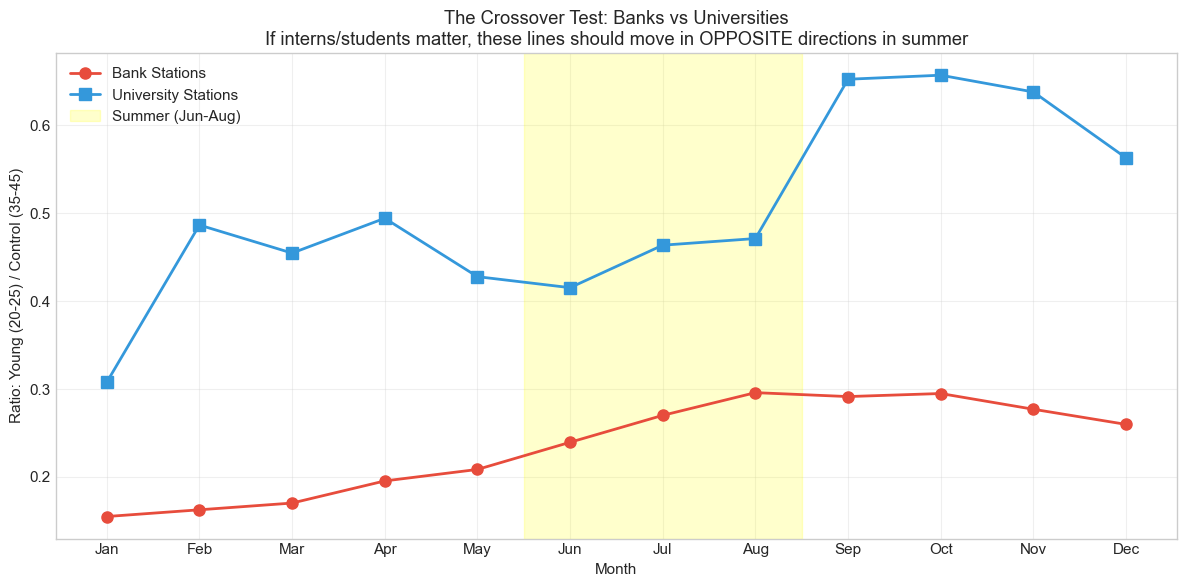


Crossover Test Results:
Bank stations - Summer change in young/control ratio: +19.9%
University stations - Summer change: -13.5%

Difference (crossover magnitude): 33.4pp

Interpretation:
- Positive bank change = more young people at banks in summer (interns arriving)
- Negative university change = fewer young people at universities (students leaving)


In [12]:
# Combine bank and university data
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(range(1, 13), avg_by_month['ratio'], marker='o', linewidth=2, 
        color=INTERN_COLOR, label='Bank Stations', markersize=8)
ax.plot(range(1, 13), uni_avg_by_month['ratio'], marker='s', linewidth=2, 
        color=STUDENT_COLOR, label='University Stations', markersize=8)

# Shade summer
ax.axvspan(5.5, 8.5, alpha=0.2, color='yellow', label='Summer (Jun-Aug)')

ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_labels)
ax.set_xlabel('Month')
ax.set_ylabel('Ratio: Young (20-25) / Control (35-45)')
ax.set_title('The Crossover Test: Banks vs Universities\nIf interns/students matter, these lines should move in OPPOSITE directions in summer')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quantify the crossover
bank_summer_change = (summer_ratio - nonsummer_ratio) / nonsummer_ratio * 100
uni_summer_change = (uni_summer - uni_academic) / uni_academic * 100

print("\nCrossover Test Results:")
print("=" * 50)
print(f"Bank stations - Summer change in young/control ratio: {bank_summer_change:+.1f}%")
print(f"University stations - Summer change: {uni_summer_change:+.1f}%")
print(f"\nDifference (crossover magnitude): {bank_summer_change - uni_summer_change:.1f}pp")
print("\nInterpretation:")
print("- Positive bank change = more young people at banks in summer (interns arriving)")
print("- Negative university change = fewer young people at universities (students leaving)")

## 8. Fine-Grained Timing: Week-by-Week During Transition

Let's zoom in on the critical weeks:
- Late May → Early June (intern arrival)
- Late August → Early September (intern departure / student arrival)

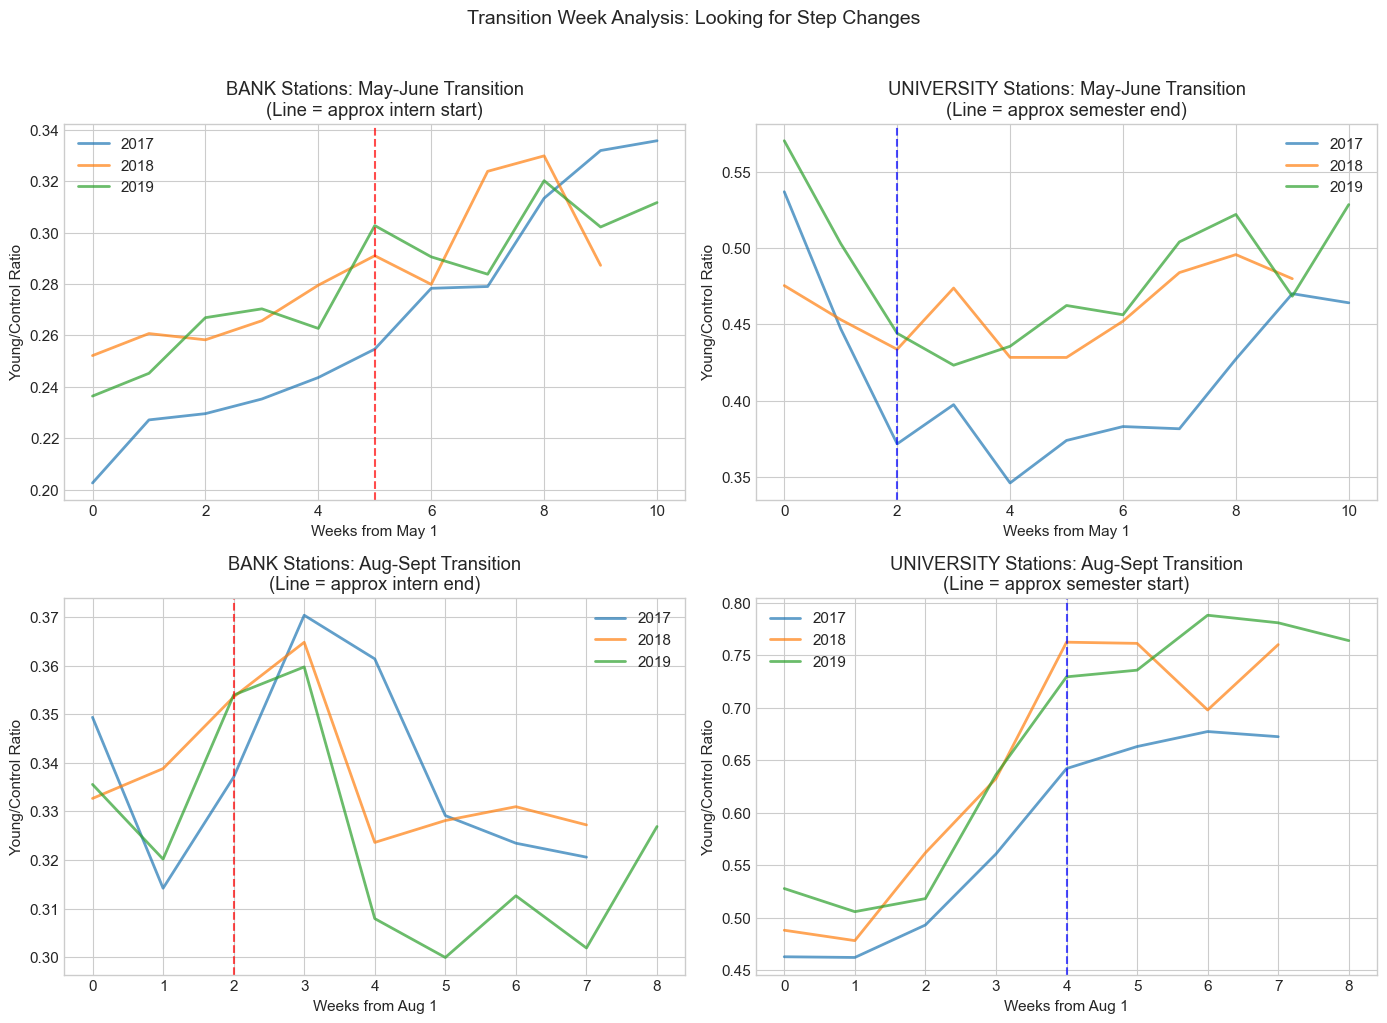

In [13]:
# Get weekly data for transition periods
def get_transition_data(weekly_df, dest_type, start_date, end_date):
    """Get weekly young/control ratio for a specific period"""
    young = weekly_df[
        (weekly_df['dest_type'] == dest_type) &
        (weekly_df['age_group'] == 'young_20_25') &
        (weekly_df['gender'] == 'male') &
        (weekly_df['trip_type'] == 'commute') &
        (weekly_df['week'] >= start_date) &
        (weekly_df['week'] <= end_date)
    ].groupby('week')['trips'].sum()
    
    control = weekly_df[
        (weekly_df['dest_type'] == dest_type) &
        (weekly_df['age_group'] == 'control_35_45') &
        (weekly_df['gender'] == 'male') &
        (weekly_df['trip_type'] == 'commute') &
        (weekly_df['week'] >= start_date) &
        (weekly_df['week'] <= end_date)
    ].groupby('week')['trips'].sum()
    
    merged = pd.DataFrame({'young': young, 'control': control})
    merged['ratio'] = merged['young'] / merged['control']
    return merged.reset_index()

# Average across years for the May-June transition
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top row: Summer arrival (May-June)
ax = axes[0, 0]
for year in [2017, 2018, 2019]:
    data = get_transition_data(weekly_data, 'bank', f'{year}-05-01', f'{year}-07-15')
    # Normalize to week number within period
    data['week_num'] = range(len(data))
    ax.plot(data['week_num'], data['ratio'], label=str(year), alpha=0.7, linewidth=2)

ax.axvline(x=5, color='red', linestyle='--', alpha=0.7)  # Approx week of June 8
ax.set_xlabel('Weeks from May 1')
ax.set_ylabel('Young/Control Ratio')
ax.set_title('BANK Stations: May-June Transition\n(Line = approx intern start)')
ax.legend()

ax = axes[0, 1]
for year in [2017, 2018, 2019]:
    data = get_transition_data(weekly_data, 'university', f'{year}-05-01', f'{year}-07-15')
    data['week_num'] = range(len(data))
    ax.plot(data['week_num'], data['ratio'], label=str(year), alpha=0.7, linewidth=2)

ax.axvline(x=2, color='blue', linestyle='--', alpha=0.7)  # Approx end of semester
ax.set_xlabel('Weeks from May 1')
ax.set_ylabel('Young/Control Ratio')
ax.set_title('UNIVERSITY Stations: May-June Transition\n(Line = approx semester end)')
ax.legend()

# Bottom row: Fall transition (Aug-Sept)
ax = axes[1, 0]
for year in [2017, 2018, 2019]:
    data = get_transition_data(weekly_data, 'bank', f'{year}-08-01', f'{year}-09-30')
    data['week_num'] = range(len(data))
    ax.plot(data['week_num'], data['ratio'], label=str(year), alpha=0.7, linewidth=2)

ax.axvline(x=2, color='red', linestyle='--', alpha=0.7)  # Approx intern end
ax.set_xlabel('Weeks from Aug 1')
ax.set_ylabel('Young/Control Ratio')
ax.set_title('BANK Stations: Aug-Sept Transition\n(Line = approx intern end)')
ax.legend()

ax = axes[1, 1]
for year in [2017, 2018, 2019]:
    data = get_transition_data(weekly_data, 'university', f'{year}-08-01', f'{year}-09-30')
    data['week_num'] = range(len(data))
    ax.plot(data['week_num'], data['ratio'], label=str(year), alpha=0.7, linewidth=2)

ax.axvline(x=4, color='blue', linestyle='--', alpha=0.7)  # Approx semester start
ax.set_xlabel('Weeks from Aug 1')
ax.set_ylabel('Young/Control Ratio')
ax.set_title('UNIVERSITY Stations: Aug-Sept Transition\n(Line = approx semester start)')
ax.legend()

plt.suptitle('Transition Week Analysis: Looking for Step Changes', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 9. Summary: Evidence for Intern/Student Effects

In [14]:
print("="*70)
print("SUMMARY: Evidence for Intern and Student Effects")
print("="*70)

print("\n--- IDENTIFICATION STRATEGY ---")
print("We used multiple layers of controls:")
print("  1. Age control: 35-45 year olds at same locations (no interns/students)")
print("  2. Location control: Non-bank/university commercial areas")
print("  3. Timing: Step-change analysis around known program dates")
print("  4. Crossover test: Banks and universities should move OPPOSITE")

print("\n--- KEY FINDINGS ---")

print(f"\n1. INTERN EFFECT (Banks):")
print(f"   - Young/Control ratio increases {bank_summer_change:+.1f}% in summer")
print(f"   - DiD effect (vs control locations): {banks_change - control_change:+.1f}pp")

print(f"\n2. STUDENT EFFECT (Universities):")
print(f"   - Young/Control ratio changes {uni_summer_change:+.1f}% in summer")
print(f"   - Expected direction: negative (students leaving)")

print(f"\n3. CROSSOVER MAGNITUDE:")
print(f"   - Banks vs Universities summer change: {bank_summer_change - uni_summer_change:.1f}pp")
print(f"   - This is hard to explain by weather alone")

print("\n--- LIMITATIONS ---")
print("  - We have not yet controlled for weather (next step)")
print("  - Step-changes may be gradual due to staggered start dates")
print("  - Some overlap between categories (finance students, etc.)")

print("\n--- NEXT STEPS ---")
print("  1. Add weather data to control for temperature/precipitation")
print("  2. Use regression with week fixed effects")
print("  3. Test robustness with different age cutoffs")
print("  4. Look at specific bank/university pairs")

SUMMARY: Evidence for Intern and Student Effects

--- IDENTIFICATION STRATEGY ---
We used multiple layers of controls:
  1. Age control: 35-45 year olds at same locations (no interns/students)
  2. Location control: Non-bank/university commercial areas
  3. Timing: Step-change analysis around known program dates
  4. Crossover test: Banks and universities should move OPPOSITE

--- KEY FINDINGS ---

1. INTERN EFFECT (Banks):
   - Young/Control ratio increases +19.9% in summer
   - DiD effect (vs control locations): +4.0pp

2. STUDENT EFFECT (Universities):
   - Young/Control ratio changes -13.5% in summer
   - Expected direction: negative (students leaving)

3. CROSSOVER MAGNITUDE:
   - Banks vs Universities summer change: 33.4pp
   - This is hard to explain by weather alone

--- LIMITATIONS ---
  - We have not yet controlled for weather (next step)
  - Step-changes may be gradual due to staggered start dates
  - Some overlap between categories (finance students, etc.)

--- NEXT STEPS -

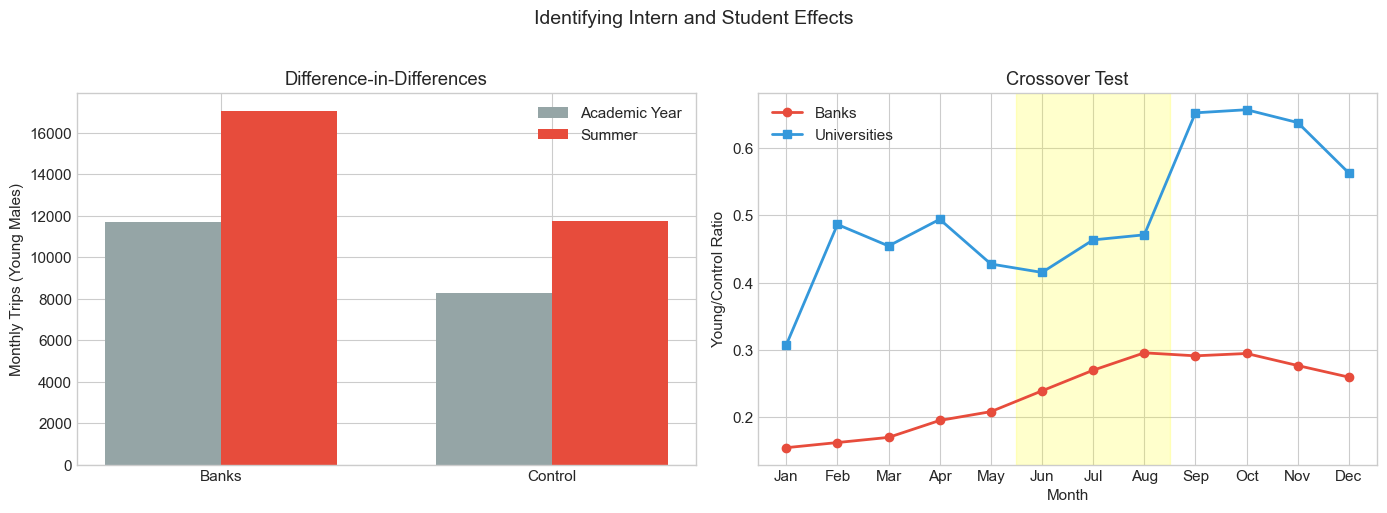

Saved figure to logs/intern_student_identification.png


In [15]:
# Save key figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: DiD
ax = axes[0]
x = np.array([0, 1])
width = 0.35
ax.bar(x - width/2, [banks_academic_monthly, control_academic_monthly], width, 
       label='Academic Year', color=CONTROL_COLOR)
ax.bar(x + width/2, [banks_summer_monthly, control_summer_monthly], width, 
       label='Summer', color=INTERN_COLOR)
ax.set_xticks(x)
ax.set_xticklabels(['Banks', 'Control'])
ax.set_ylabel('Monthly Trips (Young Males)')
ax.set_title('Difference-in-Differences')
ax.legend()

# Right: Crossover
ax = axes[1]
ax.plot(range(1, 13), avg_by_month['ratio'], marker='o', linewidth=2, 
        color=INTERN_COLOR, label='Banks')
ax.plot(range(1, 13), uni_avg_by_month['ratio'], marker='s', linewidth=2, 
        color=STUDENT_COLOR, label='Universities')
ax.axvspan(5.5, 8.5, alpha=0.2, color='yellow')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_labels)
ax.set_xlabel('Month')
ax.set_ylabel('Young/Control Ratio')
ax.set_title('Crossover Test')
ax.legend()

plt.suptitle('Identifying Intern and Student Effects', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../logs/intern_student_identification.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved figure to logs/intern_student_identification.png")